Covid-19 Dataset was downloaded from: https://www.kaggle.com/datasets/meirnizri/covid19-dataset

In [1]:
#libraries
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import missingno as msno

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.linear_model import LogisticRegression
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split

#Libraries for Forward Selection
import joblib
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier


from scipy import stats
import os
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

#!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
file = ('/content/Covid _19 _Dataset.csv')  
#covid_ori_df is the original data
covid_ori_df = pd.read_csv(file)
covid_ori_df.shape
#covidData = covid_ori_df.copy( deep= True )

(1048575, 21)

In [3]:
# converting missing data as nan in original data

#replace CLASIFFICATION_FINAL with 1,2,3 if patient is in different stages of Covid Exposure and 0 if patient is not a carrier of Covid
covid_ori_df.loc[covid_ori_df['CLASIFFICATION_FINAL']>3, 'CLASIFFICATION_FINAL'] = 0

# replace every column except CLASIFFICATION_FINAL with 97,98 and 99 with nan values and value 1 which is Yes nad 2 which is no is changed to 0
replaceMap_dict = { 1:1, 2:0, 97:np.nan, 98:np.nan, 99:np.nan, '9999-99-99':0 }
covidData_noClassification = covid_ori_df.drop(columns = 'CLASIFFICATION_FINAL').replace( replaceMap_dict )

#concat for classification_final column as it was dropped in above step
covid_ori_df = pd.concat(  [ covidData_noClassification, covid_ori_df['CLASIFFICATION_FINAL'] ], axis= 'columns'  )

# changing DATE_DIED column having an actual Date to 1 which is the person has Died Due to covid
covid_ori_df.loc[ covid_ori_df['DATE_DIED'] !=0, 'DATE_DIED' ] = 1
covid_ori_df.DATE_DIED.unique()

array([1, 0], dtype=object)

In [4]:
# impute missing value in original data
covid_ori_df.columns
#dropping 'MEDICAL_UNIT' which has irrelevant data and it does not explain my research question
covid_ori_df.drop( columns= 'MEDICAL_UNIT', inplace= True )
#numerical column
num_col_ls = [ 'CLASIFFICATION_FINAL','AGE' ] 
cat_col_ls = covid_ori_df.drop( columns= num_col_ls ).columns

# impute missing values of categorical column to their mode
for col in cat_col_ls:
    covid_ori_df[col].fillna(covid_ori_df[col].mode()[0], inplace=True)

# impute numerical col: "AGE" to their mean and classification doesn't have missing values
mean_value = covid_ori_df['AGE'].mean()
covid_ori_df['AGE'].fillna(mean_value, inplace=True)

covid_ori_df['Death'] = covid_ori_df['DATE_DIED']
covid_ori_df.drop( columns= 'DATE_DIED', inplace= True )

# convert all dtypes into int
covid_ori_df = covid_ori_df.astype(np.int8)
#covid_ori_df.dtypes

#  label encoding for CLASIFFICATION_FINAL since it is the ordinal variable
label_encoder = sklearn.preprocessing.LabelEncoder()
covid_ori_df['CLASIFFICATION_FINAL'] = label_encoder.fit_transform( covid_ori_df['CLASIFFICATION_FINAL'] )
#covid_ori_df

# one hot encoding for categorical binary nominal variable
miss_cat_colm = [ 'PATIENT_TYPE','INTUBED', 'PREGNANT', 'ICU', 'USMER', 'SEX', 'Death', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO' ]
OHEncoder = sklearn.preprocessing.OneHotEncoder( sparse= False, drop= 'first', dtype= np.int8 )
OHEncoded_np = OHEncoder.fit_transform( covid_ori_df[miss_cat_colm] )
OHEncoded_df = pd.DataFrame( OHEncoded_np, index= covid_ori_df.index, columns= OHEncoder.get_feature_names_out (miss_cat_colm) )
covid_ori_df = covid_ori_df.drop( miss_cat_colm, axis= 1 )\
                .merge( OHEncoded_df, left_index= True, right_index= True )
cols_to_rename = covid_ori_df.columns[  covid_ori_df.columns.str.endswith('_1') ]
covid_ori_df = covid_ori_df.rename(  columns={col: col.replace('_1', '')  for col in cols_to_rename}  )
cols_to_rename = covid_ori_df.columns[  covid_ori_df.columns.str.endswith('_1') ]
covid_ori_df = covid_ori_df.rename(  columns={col: col.replace('_1', '')  for col in cols_to_rename}  )
#covid_ori_df

<Axes: >

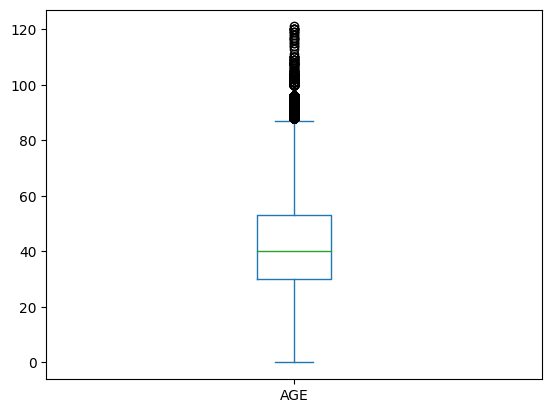

In [5]:
#To remove outliers in my dataset
covid_ori_df.AGE.plot( kind= 'box' )

121 87


<Axes: >

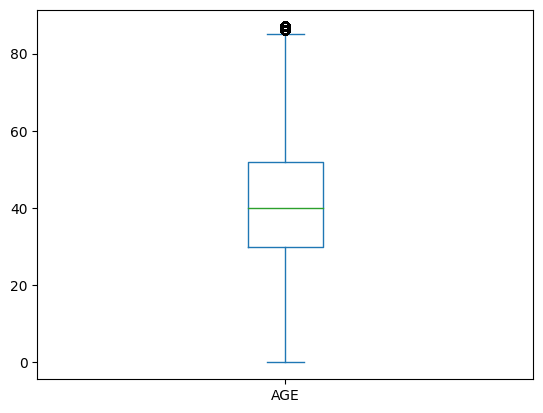

In [6]:
Q1 = covid_ori_df['AGE'].quantile(0.25)
Q3 = covid_ori_df['AGE'].quantile(0.75)
IQR = Q3 - Q1
l_bound = Q1 - (1.5 * IQR)
u_bound = Q3 + (1.5 * IQR)

covid_removeOutlier_df = covid_ori_df[(covid_ori_df['AGE'] >= l_bound) & (covid_ori_df['AGE'] <= u_bound)]
print( covid_ori_df.AGE.max(), covid_removeOutlier_df.AGE.max() )
covid_removeOutlier_df.AGE.plot( kind= 'box' )

Wrapper Method: Forward Selection

In [7]:
#Libraries for Forward Selection
import joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

x = covid_removeOutlier_df.drop( columns= 'Death' ) #independent variable
y = covid_removeOutlier_df['Death'] #dependent variable

#Defining Forward Selection(Sequential)
sq_FS = SFS(  LogisticRegression(), k_features= 5, forward= True, floating=False,  # <-- based on above results
              scoring = 'r2', cv = 5 )
sq_FS.fit(x, y)

FS_features = pd.DataFrame(sq_FS.subsets_).transpose()
FS_features

,feature_idx,cv_scores,avg_score,feature_names
1,"(3,)","[0.1371276833766406, 0.20195364131888183, 0.23...",0.191254,"(INTUBED,)"
2,"(0, 3)","[0.13985171328705748, 0.2118467779967469, 0.23...",0.193304,"(AGE, INTUBED)"
3,"(0, 3, 4)","[0.13992339828470002, 0.21285042954377675, 0.2...",0.193534,"(AGE, INTUBED, PREGNANT)"
4,"(0, 3, 4, 11)","[0.13978002828941494, 0.2126353613551275, 0.23...",0.193318,"(AGE, INTUBED, PREGNANT, ASTHMA)"
5,"(0, 3, 4, 11, 18)","[0.13978002828941494, 0.21120157343079915, 0.2...",0.19306,"(AGE, INTUBED, PREGNANT, ASTHMA, TOBACCO)"


In [10]:
# select features based on forward selection on data set where missing values are imputed and outliers are adjusted
covid_df_FS = covid_removeOutlier_df[ ['INTUBED','AGE','PREGNANT','TOBACCO','ASTHMA', 'Death'] ]
#covid_df_FS

Comparing the efficiency of ML model with Features Selected by Forward Selection

In [9]:
#diving the dataset into train and test sets

#selecting dependent and independent variable as x and y
x = covid_df_FS.drop( "Death", axis= 1 )
y = covid_df_FS["Death"]

x_train, x_test, y_train, y_test= train_test_split( x, y, test_size= 0.3, random_state= 0 )

random_underS = RandomUnderSampler(random_state=0)
x, y = random_underS.fit_resample(x,y)

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Logistic Regression ---------------------------' )
## logistic Regression

LogiReg = LogisticRegression()
LogiReg.fit(x_train, y_train)
predict_LR = LogiReg.predict(x_test)
logiR_score = accuracy_score(y_test, predict_LR)
print(classification_report(y_test,predict_LR))
print("The percentage of accuracy of Logistic Regression is: ", logiR_score)
print('Test Score: ', LogiReg.score(x_test, y_test))
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predict_LR ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predict_LR ))

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Random Forest ---------------------------' )

## Random Forest
Random_Forest = RandomForestClassifier()
Random_Forest.fit(x_train, y_train)
predicted_RF = Random_Forest.predict(x_test)
RF_score = accuracy_score(y_test, predicted_RF)
print(classification_report(y_test,predicted_RF))
print('The percentage of accuracy of Random Forest (on test data) is: ', RF_score )
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predicted_RF ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predicted_RF ))

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Naive Bayes ---------------------------' )

## Naive Bayes
Nbayes = BernoulliNB()
Nbayes.fit(x_train, y_train)
predicted_NB = Nbayes.predict(x_test)
NB_score = accuracy_score(y_test, predicted_NB)
print(classification_report(y_test,predicted_NB))
print("The percentage of accuracy of Naive-Bayes (on test data) is:", NB_score)
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predicted_NB ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predicted_NB ))

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Decision Tree ---------------------------' )

## Decision Tree
Decision_T =  DecisionTreeClassifier()
Decision_T.fit(x_train, y_train)
predicted_DT = Decision_T.predict(x_test)
DT_score = accuracy_score(y_test, predicted_DT)
print(classification_report(y_test,predicted_DT))
print("The percentage of accuracy of Decision Tree is (on test data) :", DT_score)
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predicted_DT ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predicted_DT ))



-------------------------------------------------------------------------------------
----------------------------- Logistic Regression ---------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    290322
           1       0.82      0.32      0.46     22662

    accuracy                           0.95    312984
   macro avg       0.88      0.66      0.72    312984
weighted avg       0.94      0.95      0.93    312984

The percentage of accuracy of Logistic Regression is:  0.945700099685607
Test Score:  0.945700099685607
Matthewus corr coefficient: 0.49281312572057945
Brier_score is: 0.054299900314393065

-------------------------------------------------------------------------------------
----------------------------- Random Forest ---------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    290322
           1       0.80      0.34      0.47     226

Embeded Method: Lasso Ridge Regression

In [11]:
import sklearn
# data x y 
# covidData
x = covid_removeOutlier_df.drop( "Death", axis= 1 )
y = covid_removeOutlier_df[ "Death" ]
lamda_rng = np.logspace( start= -4, stop= 4, num= 50 )
cv_Score_mean, cv_Score_SD = [], []
coeffi_dict = {}
for e_lamda in lamda_rng:
    linReg_Lasso_obj = sklearn.linear_model.Lasso( alpha= e_lamda )
    coeffi_dict[e_lamda] = linReg_Lasso_obj.fit( x,y ).coef_
    # Performing 10-fold Cross Validation
    cvScore = sklearn.model_selection.cross_val_score( estimator= linReg_Lasso_obj, X= x, y= y, cv= 10 )    
    # mean and Standard Deviation of Cross Validation score
    cv_Score_mean.append( np.mean(cvScore) );           cv_Score_SD.append( np.std(cvScore) )

In [12]:
w_ls = []
for e_key in coeffi_dict:
    for e_w in range( len(coeffi_dict[e_key]) ):
        w_ls.append(  coeffi_dict[e_key][e_w] )

w_array = np.reshape(  w_ls,
                     ( len(w_ls)//len(coeffi_dict[e_key]), len(coeffi_dict[e_key]) )
                  )
w_Lasso_dataframe = pd.DataFrame( w_array )
w_Lasso_dataframe['lamda'] = coeffi_dict.keys()

w_Lasso_dataframe.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,lamda
0,0.001900,0.009341,-0.153035,0.493761,-0.00343,-0.082163,0.006689,-0.012366,0.119182,0.022603,0.009485,-0.005517,-0.0,0.009284,0.006820,0.0,-0.000448,0.049518,-0.002377,0.000100
1,0.001913,0.009332,-0.153182,0.491387,-0.00000,-0.077721,0.006582,-0.012229,0.118844,0.022357,0.006043,-0.003872,0.0,0.009121,0.005156,0.0,-0.000078,0.047327,-0.001634,0.000146
2,0.001929,0.009326,-0.153462,0.487910,-0.00000,-0.071215,0.006421,-0.011942,0.118335,0.022021,0.001051,-0.001452,0.0,0.008938,0.002775,0.0,-0.000000,0.044090,-0.000518,0.000212


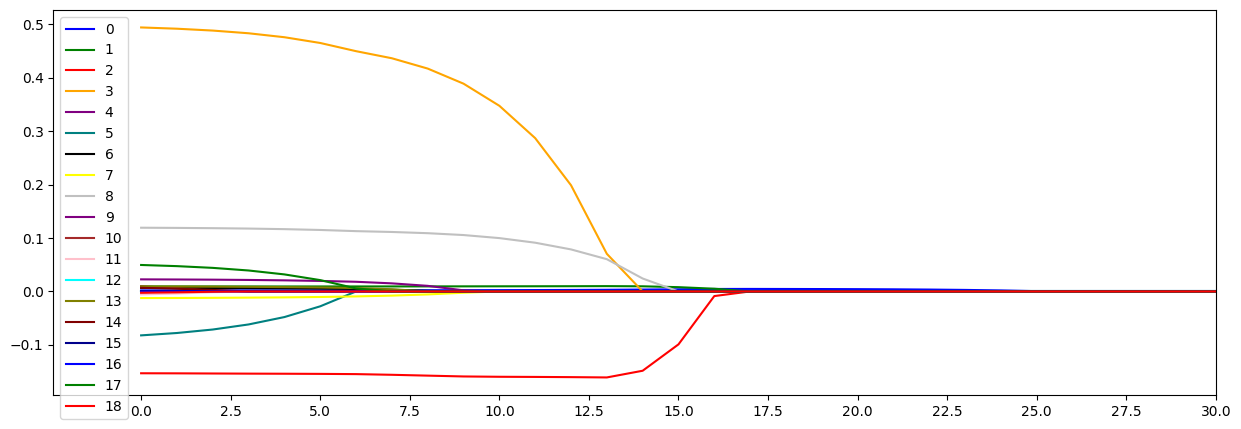

In [13]:
import matplotlib.ticker as mtick
fg,ax = plt.subplots( figsize= (15,5) )
all_color_ls = ['blue', 'green', 'red', 'orange', 'purple', 'teal', 'black', 'yellow', 'silver', 'purple', 'brown', 'pink', 'cyan', 'olive', 'maroon', 'darkblue' ]
w_Lasso_dataframe.drop('lamda',axis=1).plot( ax= ax, color= all_color_ls )
ax.set_xticklabels( w_Lasso_dataframe['lamda'], rotation= 0 )
ax.xaxis.set_major_formatter( mtick.FormatStrFormatter('%2.1f') )
ax.set_xlim( right= 30 )
ax.locator_params( axis= 'x', nbins= 15 )
plt.show()

In [20]:
import_featurebyindex = [ 2, 9, 3, 1, 8]
import_column = []
for e_impFeature in import_featurebyindex:
  import_column.append( list(x.columns)[e_impFeature] )
import_column

['PATIENT_TYPE', 'DIABETES', 'INTUBED', 'CLASIFFICATION_FINAL', 'PNEUMONIA']

In [21]:
covid_df1 = covid_removeOutlier_df[ ['PATIENT_TYPE', 'CLASIFFICATION_FINAL', 'DIABETES', 'INTUBED','PNEUMONIA', 'Death'] ]
covid_df1

x = covid_df1.drop( "Death", axis= 1 )
y = covid_df1["Death"]

random_underS = RandomUnderSampler(random_state=0)
x, y = random_underS.fit_resample(x,y)

x_train, x_test, y_train, y_test= train_test_split( x, y, test_size= 0.3, random_state= 0 )

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Logistic Regression ---------------------------' )
## logistic Regression

LogiReg = LogisticRegression()
LogiReg.fit(x_train, y_train)
predict_LR = LogiReg.predict(x_test)
logiR_score = accuracy_score(y_test, predict_LR)
print(classification_report(y_test,predict_LR))
print("The percentage of accuracy of Logistic Regression is: ", logiR_score)
print('Test Score: ', LogiReg.score(x_test, y_test))
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predict_LR ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predict_LR ))

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Random Forest ---------------------------' )

## Random Forest
Random_Forest = RandomForestClassifier()
Random_Forest.fit(x_train, y_train)
predicted_RF = Random_Forest.predict(x_test)
RF_score = accuracy_score(y_test, predicted_RF)
print(classification_report(y_test,predicted_RF))
print('The percentage of accuracy of Random Forest (on test data) is: ', RF_score )
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predicted_RF ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predicted_RF ))

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Naive Bayes ---------------------------' )

## Naive Bayes
Nbayes = BernoulliNB()
Nbayes.fit(x_train, y_train)
predicted_NB = Nbayes.predict(x_test)
NB_score = accuracy_score(y_test, predicted_NB)
print(classification_report(y_test,predicted_NB))
print("The percentage of accuracy of Naive-Bayes (on test data) is:", NB_score)
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predicted_NB ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predicted_NB ))

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Decision Tree ---------------------------' )

## Decision Tree
Decision_T =  DecisionTreeClassifier()
Decision_T.fit(x_train, y_train)
predicted_DT = Decision_T.predict(x_test)
DT_score = accuracy_score(y_test, predicted_DT)
print(classification_report(y_test,predicted_DT))
print("The percentage of accuracy of Decision Tree is (on test data) :", DT_score)
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predicted_DT ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predicted_DT ))


-------------------------------------------------------------------------------------
----------------------------- Logistic Regression ---------------------------
              precision    recall  f1-score   support

           0       0.87      0.90      0.88     22353
           1       0.89      0.87      0.88     22744

    accuracy                           0.88     45097
   macro avg       0.88      0.88      0.88     45097
weighted avg       0.88      0.88      0.88     45097

The percentage of accuracy of Logistic Regression is:  0.8834734017783888
Test Score:  0.8834734017783888
Matthewus corr coefficient: 0.7672536445162214
Brier_score is: 0.1165265982216112

-------------------------------------------------------------------------------------
----------------------------- Random Forest ---------------------------
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     22353
           1       0.87      0.95      0.91     2274

Filtration Method: Chi-Square Test

In [22]:
X = covid_removeOutlier_df.drop( "Death", axis= 1 )
Y = covid_removeOutlier_df[ "Death" ]

import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#apply SelectKBest class to extract top 5 best features
best_feat = SelectKBest(score_func=chi2, k=10)
fit_dataframe = best_feat.fit(X,Y)
dataframe_scores = pd.DataFrame(fit_dataframe.scores_)
dataframe_columns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
features_Scores = pd.concat([dataframe_columns,dataframe_scores],axis=1)
features_Scores.columns = ['Specs','Score']  #naming the dataframe columns
print(features_Scores.nlargest(5,'Score'))  #print 5 best features

                  Specs          Score
0                   AGE  686990.133774
3               INTUBED  250616.583127
8             PNEUMONIA  198864.795841
1  CLASIFFICATION_FINAL   68939.531361
2          PATIENT_TYPE   52095.601073


In [23]:
covid_df_chi = covid_removeOutlier_df[ ['AGE','INTUBED','PNEUMONIA','PATIENT_TYPE','CLASIFFICATION_FINAL', 'Death'] ]
covid_df_chi

,AGE,INTUBED,PNEUMONIA,PATIENT_TYPE,CLASIFFICATION_FINAL,Death
0,65,0,1,1,3,1
1,72,0,1,1,0,1
2,55,1,0,0,3,1
3,53,0,0,1,0,1
4,68,0,0,1,3,1
...,...,...,...,...,...,...
1048570,40,0,0,1,0,0
1048571,51,0,0,0,0,0
1048572,55,0,0,1,0,0
1048573,28,0,0,1,0,0


In [24]:
#diving the dataset into train and test sets
from sklearn.model_selection import train_test_split
x = covid_df_chi.drop("Death", axis=1)
y = covid_df_chi["Death"]
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.3, 
                                                    random_state=28, 
                                                    stratify=y)

random_underS = RandomUnderSampler(random_state=0)
x, y = random_underS.fit_resample(x,y)

x_train, x_test, y_train, y_test= train_test_split( x, y, test_size= 0.3, random_state= 0 )

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Logistic Regression ---------------------------' )
## logistic Regression

LogiReg = LogisticRegression()
LogiReg.fit(x_train, y_train)
predict_LR = LogiReg.predict(x_test)
logiR_score = accuracy_score(y_test, predict_LR)
print(classification_report(y_test,predict_LR))
print("The percentage of accuracy of Logistic Regression is: ", logiR_score)
print('Test Score: ', LogiReg.score(x_test, y_test))
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predict_LR ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predict_LR ))

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Random Forest ---------------------------' )

## Random Forest
Random_Forest = RandomForestClassifier()
Random_Forest.fit(x_train, y_train)
predicted_RF = Random_Forest.predict(x_test)
RF_score = accuracy_score(y_test, predicted_RF)
print(classification_report(y_test,predicted_RF))
print('The percentage of accuracy of Random Forest (on test data) is: ', RF_score )
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predicted_RF ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predicted_RF ))

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Naive Bayes ---------------------------' )

## Naive Bayes
Nbayes = BernoulliNB()
Nbayes.fit(x_train, y_train)
predicted_NB = Nbayes.predict(x_test)
NB_score = accuracy_score(y_test, predicted_NB)
print(classification_report(y_test,predicted_NB))
print("The percentage of accuracy of Naive-Bayes (on test data) is:", NB_score)
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predicted_NB ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predicted_NB ))

print( '\n-------------------------------------------------------------------------------------' )
print( '----------------------------- Decision Tree ---------------------------' )

## Decision Tree
Decision_T =  DecisionTreeClassifier()
Decision_T.fit(x_train, y_train)
predicted_DT = Decision_T.predict(x_test)
DT_score = accuracy_score(y_test, predicted_DT)
print(classification_report(y_test,predicted_DT))
print("The percentage of accuracy of Decision Tree is (on test data) :", DT_score)
print("Matthewus corr coefficient:", sklearn.metrics.matthews_corrcoef( y_test, predicted_DT ))
print("Brier_score is:", sklearn.metrics.brier_score_loss( y_test, predicted_DT ))


-------------------------------------------------------------------------------------
----------------------------- Logistic Regression ---------------------------
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     22353
           1       0.90      0.91      0.90     22744

    accuracy                           0.90     45097
   macro avg       0.90      0.90      0.90     45097
weighted avg       0.90      0.90      0.90     45097

The percentage of accuracy of Logistic Regression is:  0.9007251036654322
Test Score:  0.9007251036654322
Matthewus corr coefficient: 0.8014798304333182
Brier_score is: 0.09927489633456771

-------------------------------------------------------------------------------------
----------------------------- Random Forest ---------------------------
              precision    recall  f1-score   support

           0       0.94      0.88      0.90     22353
           1       0.89      0.94      0.91     227